In [1]:
# Install required libraries
!pip install -q timm datasets

# Import necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset
import timm

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Set up device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Configuration ---
NUM_CLASSES = 20
BATCH_SIZE = 64
IMG_SIZE = 224

# --- Load, Filter, and Prepare Dataset ---
# (This code is the same as before)
print("Loading and preparing the dataset...")
full_dataset = load_dataset("Maysee/tiny-imagenet", split='train')
all_class_names = full_dataset.features['label'].names
selected_class_names = all_class_names[:NUM_CLASSES]
class_to_idx = {name: i for i, name in enumerate(selected_class_names)}
original_class_indices = [all_class_names.index(name) for name in selected_class_names]

def filter_by_class(example):
    return example['label'] in original_class_indices
filtered_dataset = full_dataset.filter(filter_by_class)

def remap_labels(example):
    original_label_name = all_class_names[example['label']]
    example['label'] = class_to_idx[original_label_name]
    return example
remapped_dataset = filtered_dataset.map(remap_labels)

dataset_splits = remapped_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_splits['train']
val_dataset = dataset_splits['test']

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_transform(examples):
    examples['pixel_values'] = [data_transform(image.convert("RGB")) for image in examples['image']]
    return examples

train_dataset.set_transform(apply_transform)
val_dataset.set_transform(apply_transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print("\nDataLoaders created successfully. Ready for training.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.3 MB/s eta 0:00:00
Using device: cuda
Loading and preparing the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


DataLoaders created successfully. Ready for training.


In [2]:
# Model 1: ViT with 16x16 pixel patches
vit_patch16 = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False, # Must train from scratch
    num_classes=NUM_CLASSES
).to(device)

# Model 2: ViT with 32x32 pixel patches
# We use the same base model but override the patch_size argument
vit_patch32 = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=NUM_CLASSES,
    patch_size=32
).to(device)

print("--- ViT Models with Varying Patch Sizes Created ---\n")
print(f"Model 1 (16x16 patches):")
print(f"  - Number of patches (sequence length): {vit_patch16.patch_embed.num_patches}")
print(f"  - An image of size {IMG_SIZE}x{IMG_SIZE} is turned into {int(np.sqrt(vit_patch16.patch_embed.num_patches))}x{int(np.sqrt(vit_patch16.patch_embed.num_patches))} patches.")
print("-" * 40)
print(f"Model 2 (32x32 patches):")
print(f"  - Number of patches (sequence length): {vit_patch32.patch_embed.num_patches}")
print(f"  - An image of size {IMG_SIZE}x{IMG_SIZE} is turned into {int(np.sqrt(vit_patch32.patch_embed.num_patches))}x{int(np.sqrt(vit_patch32.patch_embed.num_patches))} patches.")

--- ViT Models with Varying Patch Sizes Created ---

Model 1 (16x16 patches):
  - Number of patches (sequence length): 196
  - An image of size 224x224 is turned into 14x14 patches.
----------------------------------------
Model 2 (32x32 patches):
  - Number of patches (sequence length): 49
  - An image of size 224x224 is turned into 7x7 patches.



--- Training ViT (16x16 Patches) for 5 epochs ---


Epoch 1/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 | Duration: 27.07s | Validation Acc: 20.00%


Epoch 2/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 | Duration: 27.23s | Validation Acc: 25.65%


Epoch 3/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 | Duration: 28.70s | Validation Acc: 28.60%


Epoch 4/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 | Duration: 28.08s | Validation Acc: 32.20%


Epoch 5/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 | Duration: 28.33s | Validation Acc: 33.00%

Finished Training ViT (16x16 Patches).
  - Best Validation Accuracy: 33.00%
  - Average Epoch Duration: 27.88s

--- Training ViT (32x32 Patches) for 5 epochs ---


Epoch 1/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 | Duration: 19.61s | Validation Acc: 18.10%


Epoch 2/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 | Duration: 19.56s | Validation Acc: 25.05%


Epoch 3/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 | Duration: 19.55s | Validation Acc: 27.00%


Epoch 4/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 | Duration: 19.56s | Validation Acc: 29.90%


Epoch 5/5 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 | Duration: 19.48s | Validation Acc: 31.10%

Finished Training ViT (32x32 Patches).
  - Best Validation Accuracy: 31.10%
  - Average Epoch Duration: 19.55s


================= FINAL RESULTS =================

Model Configuration       | Val Accuracy (%)     | Avg. Epoch Time (s) 
---------------------------------------------------------------------------
ViT (16x16 Patches)       | 33.00                | 27.88               
ViT (32x32 Patches)       | 31.10                | 19.55               


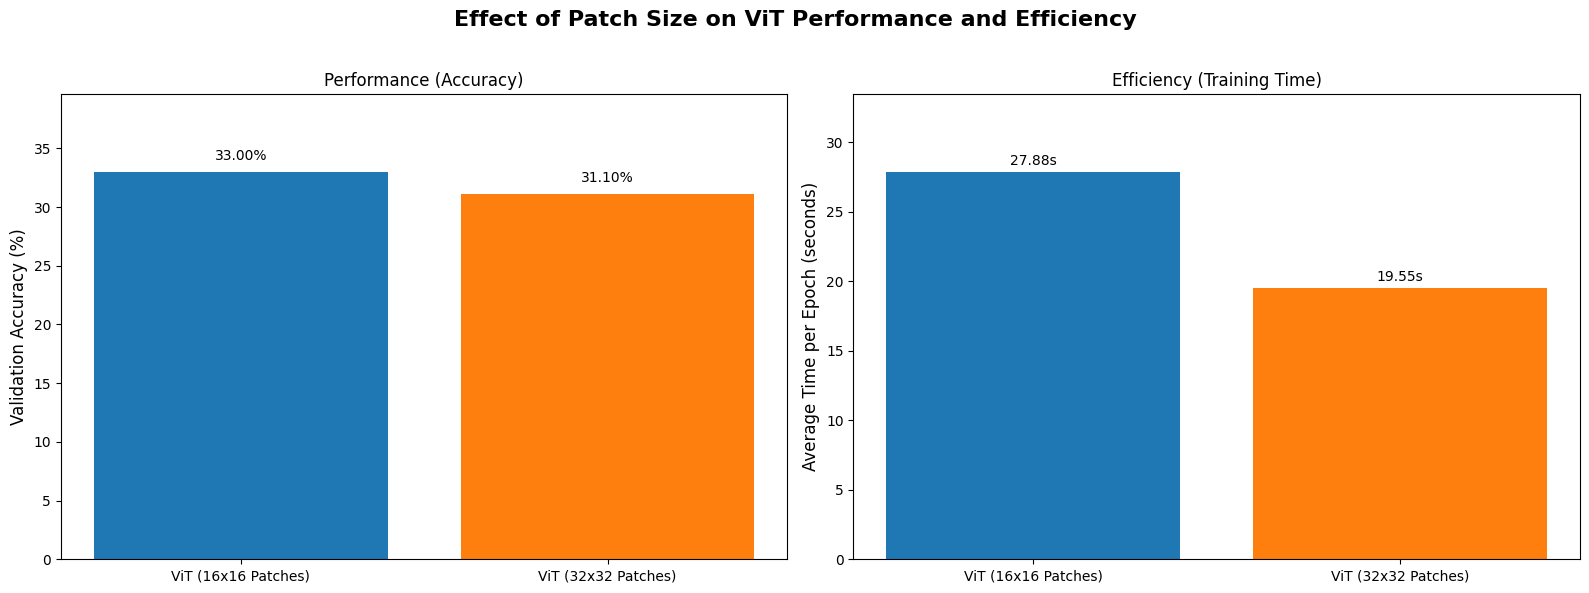

In [3]:
def train_model(model, model_name, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\n--- Training {model_name} for {epochs} epochs ---")

    best_val_acc = 0.0
    total_train_time = 0.0

    for epoch in range(epochs):
        start_time = time.time()
        # --- Training Phase ---
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        epoch_duration = end_time - start_time
        total_train_time += epoch_duration

        # --- Validation Phase ---
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs} | Duration: {epoch_duration:.2f}s | Validation Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    avg_epoch_time = total_train_time / epochs
    print(f"\nFinished Training {model_name}.")
    print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"  - Average Epoch Duration: {avg_epoch_time:.2f}s")
    return best_val_acc, avg_epoch_time

# --- Execution ---
EPOCHS = 5
results = {}

# Train each model and store both accuracy and time
acc_p16, time_p16 = train_model(vit_patch16, "ViT (16x16 Patches)", train_loader, val_loader, epochs=EPOCHS)
results['ViT (16x16 Patches)'] = {'acc': acc_p16, 'time': time_p16}

acc_p32, time_p32 = train_model(vit_patch32, "ViT (32x32 Patches)", train_loader, val_loader, epochs=EPOCHS)
results['ViT (32x32 Patches)'] = {'acc': acc_p32, 'time': time_p32}

# --- Final Comparison ---
print("\n\n================= FINAL RESULTS =================\n")
print(f"{'Model Configuration':<25} | {'Val Accuracy (%)':<20} | {'Avg. Epoch Time (s)':<20}")
print("-" * 75)
for model_name, data in results.items():
    print(f"{model_name:<25} | {data['acc']:<20.2f} | {data['time']:<20.2f}")

# --- Plotting the results ---
model_names = list(results.keys())
accuracies = [r['acc'] for r in results.values()]
times = [r['time'] for r in results.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Effect of Patch Size on ViT Performance and Efficiency', fontsize=16, weight='bold')

# Plot for Accuracy
ax1.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Performance (Accuracy)', fontsize=12)
ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax1.set_ylim(0, max(accuracies) * 1.2)
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 1, f'{acc:.2f}%', ha='center')

# Plot for Training Time
ax2.bar(model_names, times, color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Efficiency (Training Time)', fontsize=12)
ax2.set_ylabel('Average Time per Epoch (seconds)', fontsize=12)
ax2.set_ylim(0, max(times) * 1.2)
for i, t in enumerate(times):
    ax2.text(i, t + 0.5, f'{t:.2f}s', ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()